# 🎵 Analisi delle Caratteristiche Audio a Livello di Canzone con Librosa 🎵

Questo notebook si concentra sull'estrazione e analisi delle caratteristiche audio aggregate a livello di canzone intera, mostrando come le proprietà sonore complessive si correlano con le annotazioni emotive statiche (arousal e valence) del dataset DEAM.

## 1. Preparazione dell'ambiente

Importiamo le librerie necessarie per l'analisi audio e la visualizzazione dei dati.

In [2]:
import os
import glob
import librosa  # Libreria principale per l'analisi audio
import librosa.display  # Per visualizzare i grafici audio
import matplotlib.pyplot as plt  # Per creare grafici
import numpy as np  # Per calcoli matematici
import pandas as pd  # Per gestire i dati in formato tabellare
import seaborn as sns  # Per grafici statistici più avanzati
from scipy import stats  # Per calcoli statistici

# Impostiamo alcune opzioni di visualizzazione
plt.rcParams['figure.figsize'] = (14, 8)  # Dimensione predefinita dei grafici
plt.rcParams['font.size'] = 12  # Dimensione del testo nei grafici
sns.set_theme(style='whitegrid')  # Stile dei grafici seaborn

## 2. Caricamento delle annotazioni statiche

Carichiamo le annotazioni statiche medie (static_annotations_averaged_songs) dal dataset DEAM. Queste annotazioni contengono i valori medi di arousal e valence per ogni canzone.

In [3]:
# Percorso del file delle annotazioni statiche (da modificare in base alla posizione effettiva)
# Nel dataset DEAM, questo file si trova tipicamente nella cartella 'annotations/static_annotations/static_annotations_averaged_songs/'
# Per questo esempio, assumiamo che il file sia nella cartella 'DEAM_annotations'
annotations_path = 'DEAM_annotations/static_annotations_averaged_songs.csv'

# Verifichiamo se il file esiste
if not os.path.exists(annotations_path):
    print(f"Il file {annotations_path} non esiste. Utilizzeremo dati di esempio.")
    # Creiamo dati di esempio per le annotazioni statiche
    # In un caso reale, questi dati verrebbero caricati dal dataset DEAM
    song_ids = [f'song_{i}' for i in range(1, 21)]  # 20 canzoni di esempio
    
    # Generiamo valori casuali di arousal e valence per ogni canzone
    np.random.seed(42)  # Per riproducibilità
    arousal_mean = np.random.uniform(0.3, 0.8, len(song_ids))
    valence_mean = np.random.uniform(0.2, 0.9, len(song_ids))
    
    # Creiamo un DataFrame per le annotazioni statiche
    static_annotations = pd.DataFrame({
        'song_id': song_ids,
        'arousal_mean': arousal_mean,
        'valence_mean': valence_mean
    })
else:
    # Carichiamo le annotazioni statiche dal file CSV
    static_annotations = pd.read_csv(annotations_path)
    print(f"Caricate {len(static_annotations)} annotazioni statiche.")

# Mostriamo le prime righe del DataFrame
static_annotations.head()

Il file DEAM_annotations/static_annotations_averaged_songs.csv non esiste. Utilizzeremo dati di esempio.


,song_id,arousal_mean,valence_mean
0,song_1,0.487270,0.628297
1,song_2,0.775357,0.297646
2,song_3,0.665997,0.404501
3,song_4,0.599329,0.456453
4,song_5,0.378009,0.519249


## 3. Definizione della funzione per estrarre caratteristiche audio a livello di canzone

Definiamo una funzione che estrae caratteristiche audio aggregate per l'intera canzone, invece che per segmenti temporali.

In [4]:
def extract_song_features(audio_path, duration=None):
    """
    Estrae caratteristiche audio aggregate per l'intera canzone.
    
    Parameters:
    -----------
    audio_path : str
        Percorso del file audio
    duration : float, optional
        Durata in secondi da caricare (None per caricare l'intero file)
    
    Returns:
    --------
    features : dict
        Dizionario con le caratteristiche audio estratte
    """
    try:
        # Carichiamo il file audio
        y, sr = librosa.load(audio_path, duration=duration)
        
        # Calcoliamo le caratteristiche audio per l'intera canzone
        # 1. Energia (RMS)
        rms = np.mean(librosa.feature.rms(y=y)[0])
        
        # 2. Centroide spettrale (brillantezza)
        spectral_centroid = np.mean(librosa.feature.spectral_centroid(y=y, sr=sr)[0])
        
        # 3. Contrasto spettrale (differenza tra picchi e valli)
        spectral_contrast = np.mean(librosa.feature.spectral_contrast(y=y, sr=sr)[0])
        
        # 4. Rolloff spettrale (distribuzione dell'energia)
        spectral_rolloff = np.mean(librosa.feature.spectral_rolloff(y=y, sr=sr)[0])
        
        # 5. Zero crossing rate (quante volte il segnale attraversa lo zero)
        zero_crossing_rate = np.mean(librosa.feature.zero_crossing_rate(y)[0])
        
        # 6. Tempo (BPM)
        tempo, _ = librosa.beat.beat_track(y=y, sr=sr)
        
        # 7. MFCC (Mel-Frequency Cepstral Coefficients)
        mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
        mfcc_means = np.mean(mfccs, axis=1)
        
        # 8. Chroma features (rappresentazione delle classi di altezza)
        chroma = librosa.feature.chroma_stft(y=y, sr=sr)
        chroma_mean = np.mean(chroma)
        
        # Creiamo un dizionario con tutte le caratteristiche estratte
        features = {
            'rms': rms,
            'spectral_centroid': spectral_centroid,
            'spectral_contrast': spectral_contrast,
            'spectral_rolloff': spectral_rolloff,
            'zero_crossing_rate': zero_crossing_rate,
            'tempo': tempo,
            'chroma_mean': chroma_mean
        }
        
        # Aggiungiamo i coefficienti MFCC
        for i, mfcc_val in enumerate(mfcc_means):
            features[f'mfcc_{i+1}'] = mfcc_val
            
        return features
    
    except Exception as e:
        print(f"Errore nell'estrazione delle caratteristiche per {audio_path}: {e}")
        return None

## 4. Estrazione delle caratteristiche audio per un insieme di canzoni

Ora estraiamo le caratteristiche audio per un insieme di canzoni e le combiniamo con le annotazioni statiche.

In [7]:
# Percorso della cartella contenente i file audio (da modificare in base alla posizione effettiva)
audio_folder = 'DEAM_audio/MEMD_audio/'

# Verifichiamo se la cartella esiste
if not os.path.exists(audio_folder):
    print(f"La cartella {audio_folder} non esiste. Utilizzeremo dati di esempio.")
    # Creiamo dati di esempio per le caratteristiche audio
    # In un caso reale, queste caratteristiche verrebbero estratte dai file audio
    
    # Utilizziamo gli stessi song_ids delle annotazioni statiche
    song_ids = static_annotations['song_id'].tolist()
    
    # Generiamo valori casuali per le caratteristiche audio
    np.random.seed(42)  # Per riproducibilità
    features_data = []
    
    for song_id in song_ids:
        features = {
            'song_id': song_id,
            'rms': np.random.uniform(0.05, 0.25),
            'spectral_centroid': np.random.uniform(1000, 3000),
            'spectral_contrast': np.random.uniform(1, 7),
            'spectral_rolloff': np.random.uniform(2000, 8000),
            'zero_crossing_rate': np.random.uniform(0.05, 0.2),
            'tempo': np.random.uniform(80, 160),
            'chroma_mean': np.random.uniform(0.2, 0.7)
        }
        
        # Aggiungiamo i coefficienti MFCC
        for i in range(13):
            features[f'mfcc_{i+1}'] = np.random.uniform(-40, 40)
            
        features_data.append(features)
    
    # Creiamo un DataFrame con le caratteristiche audio
    audio_features_df = pd.DataFrame(features_data)
    
else:
    # Troviamo tutti i file audio nella cartella
    audio_files = glob.glob(os.path.join(audio_folder, '*.mp3'))
    print(f"Trovati {len(audio_files)} file audio.")
    
    # Estraiamo le caratteristiche audio per ogni file
    features_data = []
    
    for audio_file in audio_files[:20]:  # Limitiamo a 20 file per semplicità
        # Estraiamo l'ID della canzone dal nome del file
        song_id = os.path.basename(audio_file).split('.')[0]
        
        # Estraiamo le caratteristiche audio
        features = extract_song_features(audio_file, duration=60)  # Limitiamo a 60 secondi per semplicità
        
        if features is not None:
            # Aggiungiamo l'ID della canzone
            features['song_id'] = song_id
            features_data.append(features)
    
    # Creiamo un DataFrame con le caratteristiche audio
    audio_features_df = pd.DataFrame(features_data)

# Combiniamo le caratteristiche audio con le annotazioni statiche
# Utilizziamo una fusione (merge) sui song_id
combined_df = pd.merge(audio_features_df, static_annotations, on='song_id', how='inner')

print(f"Dataset combinato: {len(combined_df)} canzoni con caratteristiche audio e annotazioni emotive.")
combined_df.head()

Trovati 1802 file audio.
Dataset combinato: 0 canzoni con caratteristiche audio e annotazioni emotive.


,rms,spectral_centroid,spectral_contrast,spectral_rolloff,zero_crossing_rate,tempo,chroma_mean,mfcc_1,mfcc_2,mfcc_3,...,mfcc_7,mfcc_8,mfcc_9,mfcc_10,mfcc_11,mfcc_12,mfcc_13,song_id,arousal_mean,valence_mean


## 5. Analisi esplorativa delle caratteristiche audio e delle annotazioni emotive

Esploriamo la distribuzione delle caratteristiche audio e delle annotazioni emotive nel nostro dataset.

In [6]:
# Statistiche descrittive delle caratteristiche audio e delle annotazioni emotive
# Escludiamo la colonna song_id che è categorica
numeric_columns = combined_df.columns.drop('song_id')
combined_df[numeric_columns].describe()

,rms,spectral_centroid,spectral_contrast,spectral_rolloff,zero_crossing_rate,chroma_mean,mfcc_1,mfcc_2,mfcc_3,mfcc_4,...,mfcc_6,mfcc_7,mfcc_8,mfcc_9,mfcc_10,mfcc_11,mfcc_12,mfcc_13,arousal_mean,valence_mean
count,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
max,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


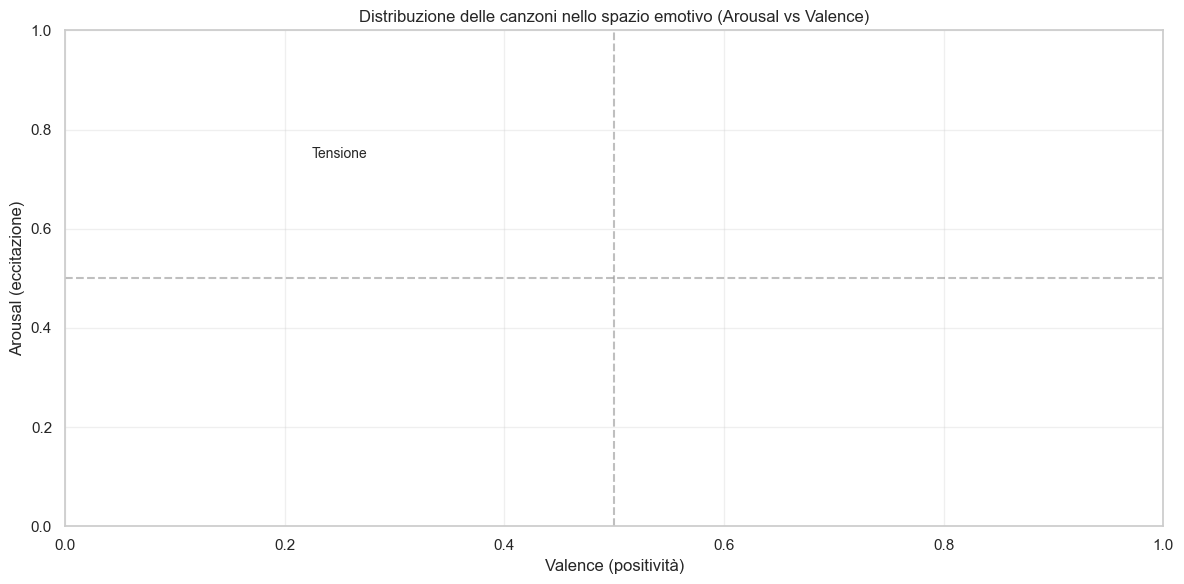

In [12]:
# Visualizziamo la distribuzione delle annotazioni emotive (arousal e valence)
plt.figure(figsize=(12, 6))

# Creiamo un grafico a dispersione (scatter plot) di arousal vs valence
plt.scatter(combined_df['valence_mean'], combined_df['arousal_mean'], alpha=0.7, s=100)

# Aggiungiamo etichette per ogni punto (opzionale)
for i, song_id in enumerate(combined_df['song_id']):
    plt.annotate(song_id, (combined_df['valence_mean'].iloc[i], combined_df['arousal_mean'].iloc[i]),
                 xytext=(5, 5), textcoords='offset points', fontsize=8)

# Aggiungiamo linee che dividono lo spazio in quadranti
plt.axhline(y=0.5, color='gray', linestyle='--', alpha=0.5)
plt.axvline(x=0.5, color='gray', linestyle='--', alpha=0.5)

# Aggiungiamo etichette per i quadranti
plt.text(0.25, 0.75, 'Tensione', ha='center', va='center', fontsize=10)
#'(Alta arousal, Bassa valence)', ha='center', va='center', fontsize=10
#plt.text(0.75, 0.75, 'Eccitazione', ha='center', va='center', fontsize=10)
#(Bassa arousal, Alta valence)', ha='center', va='center', fontsize=10)

plt.title('Distribuzione delle canzoni nello spazio emotivo (Arousal vs Valence)')
plt.xlabel('Valence (positività)')
plt.ylabel('Arousal (eccitazione)')
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

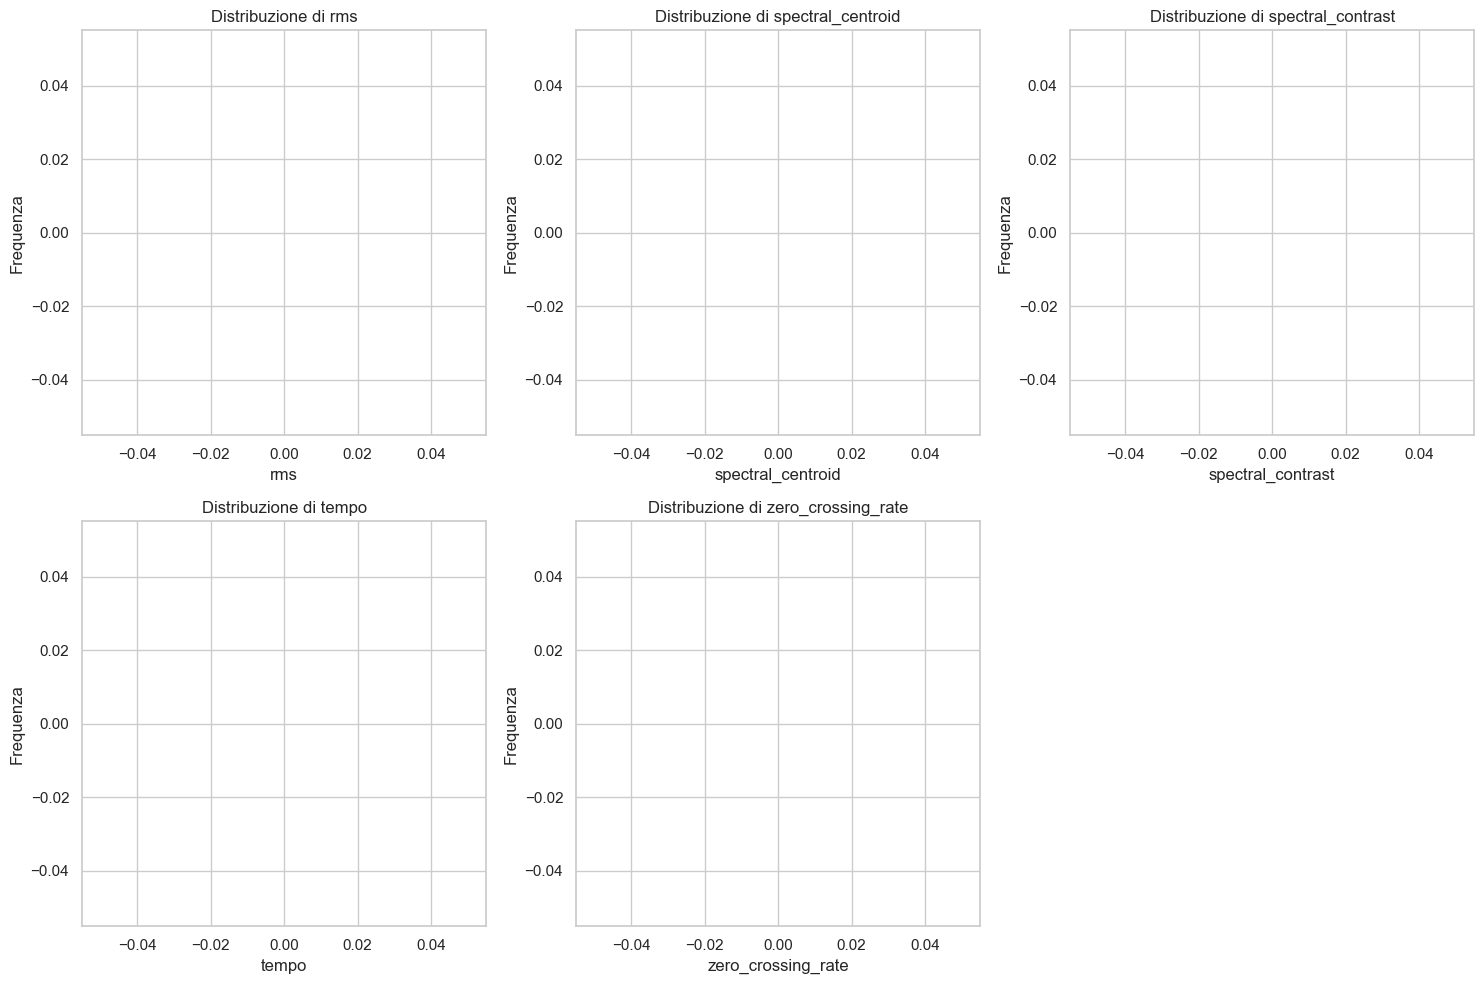

In [8]:
# Visualizziamo la distribuzione di alcune caratteristiche audio chiave
key_features = ['rms', 'spectral_centroid', 'spectral_contrast', 'tempo', 'zero_crossing_rate']

plt.figure(figsize=(15, 10))
for i, feature in enumerate(key_features):
    plt.subplot(2, 3, i+1)
    sns.histplot(combined_df[feature], kde=True)
    plt.title(f'Distribuzione di {feature}')
    plt.xlabel(feature)
    plt.ylabel('Frequenza')

plt.tight_layout()
plt.show()

## 6. Analisi della correlazione tra caratteristiche audio ed emozioni

Calcoliamo e visualizziamo la correlazione tra le caratteristiche audio estratte e le annotazioni emotive statiche.

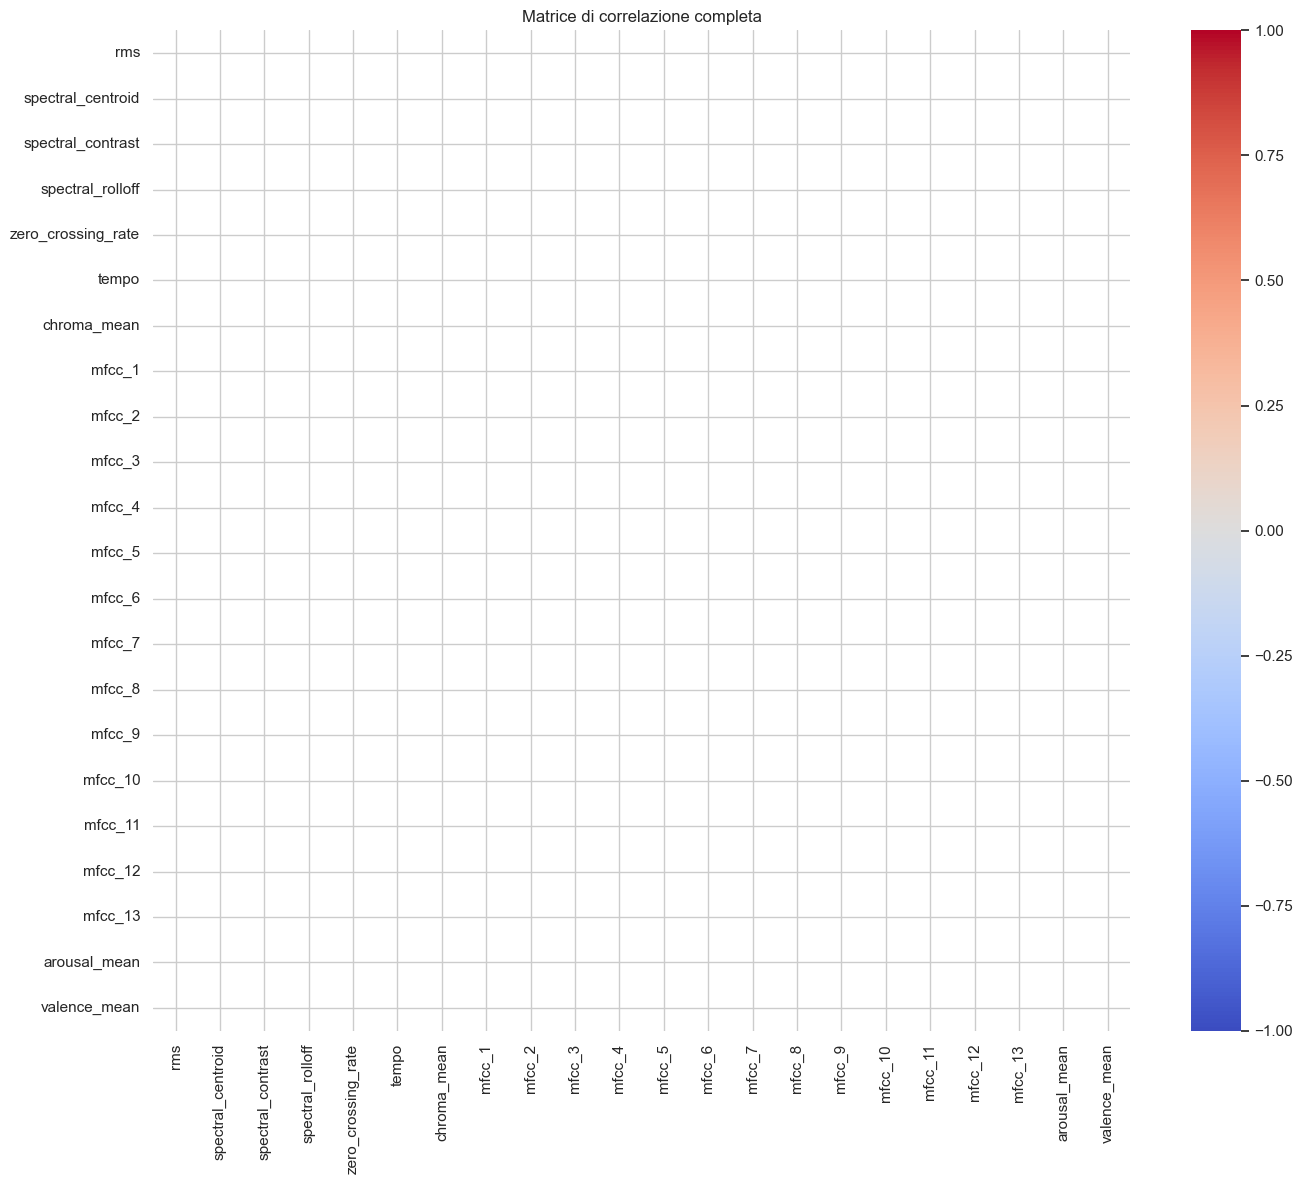

In [9]:
# Selezioniamo le colonne numeriche per l'analisi di correlazione
# Escludiamo la colonna song_id che è categorica
correlation_columns = combined_df.columns.drop('song_id')

# Calcoliamo la matrice di correlazione
correlation_matrix = combined_df[correlation_columns].corr()

# Visualizziamo la matrice di correlazione completa come heatmap
plt.figure(figsize=(14, 12))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', vmin=-1, vmax=1, center=0)
plt.title('Matrice di correlazione completa')
plt.tight_layout()
plt.show()

<Figure size 1200x1000 with 0 Axes>

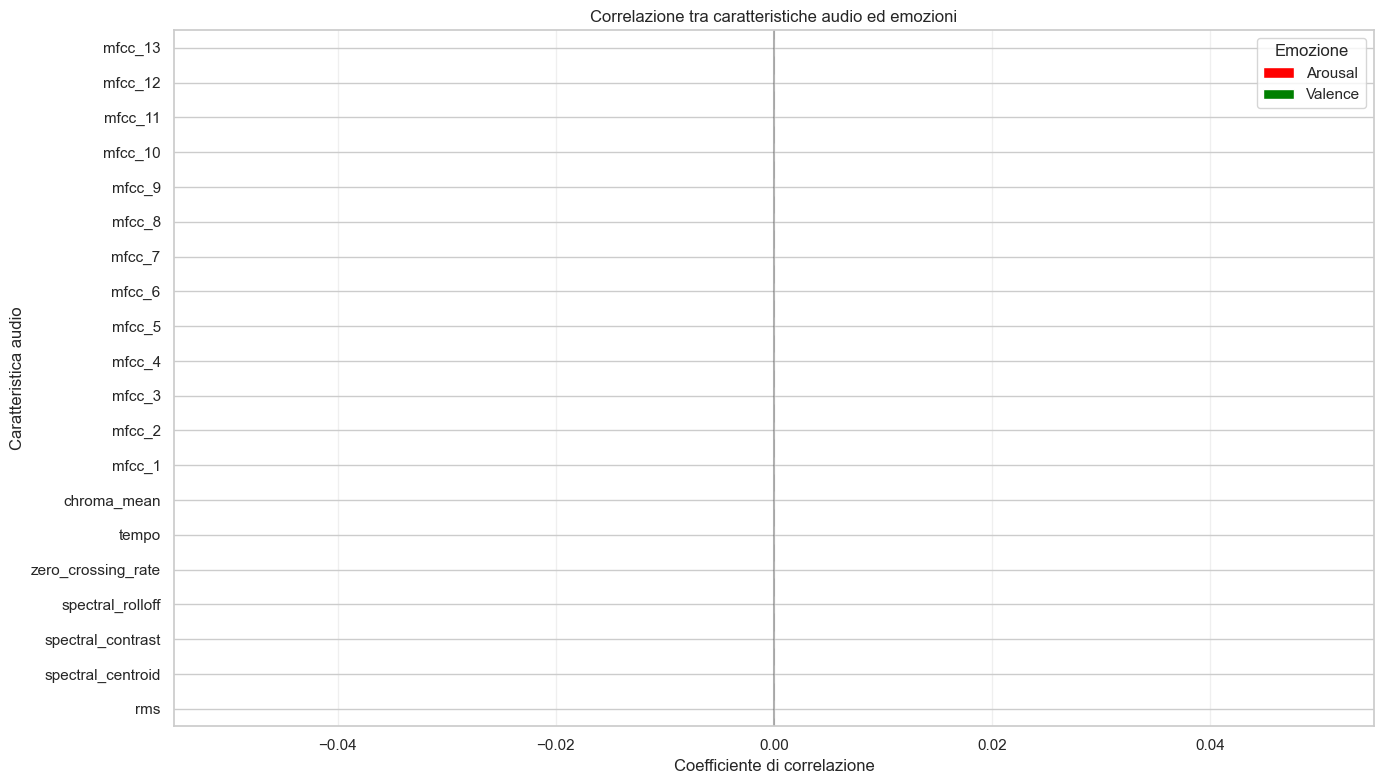

In [10]:
# Estraiamo e visualizziamo solo le correlazioni con arousal_mean e valence_mean
arousal_correlations = correlation_matrix['arousal_mean'].drop(['arousal_mean', 'valence_mean'])
valence_correlations = correlation_matrix['valence_mean'].drop(['arousal_mean', 'valence_mean'])

# Ordiniamo le correlazioni per valore assoluto decrescente
arousal_correlations = arousal_correlations.reindex(arousal_correlations.abs().sort_values(ascending=False).index)
valence_correlations = valence_correlations.reindex(valence_correlations.abs().sort_values(ascending=False).index)

# Creiamo un DataFrame per facilitare la visualizzazione
emotion_correlations = pd.DataFrame({
    'Arousal': arousal_correlations,
    'Valence': valence_correlations
})

# Visualizziamo le correlazioni come grafico a barre
plt.figure(figsize=(12, 10))
emotion_correlations.plot(kind='barh', color=['red', 'green'])
plt.title('Correlazione tra caratteristiche audio ed emozioni')
plt.xlabel('Coefficiente di correlazione')
plt.ylabel('Caratteristica audio')
plt.axvline(x=0, color='black', linestyle='-', alpha=0.3)
plt.grid(axis='x', alpha=0.3)
plt.legend(title='Emozione')
plt.tight_layout()
plt.show()

## 7. Visualizzazione delle relazioni tra caratteristiche audio ed emozioni

Visualizziamo le relazioni tra le caratteristiche audio più correlate con arousal e valence.

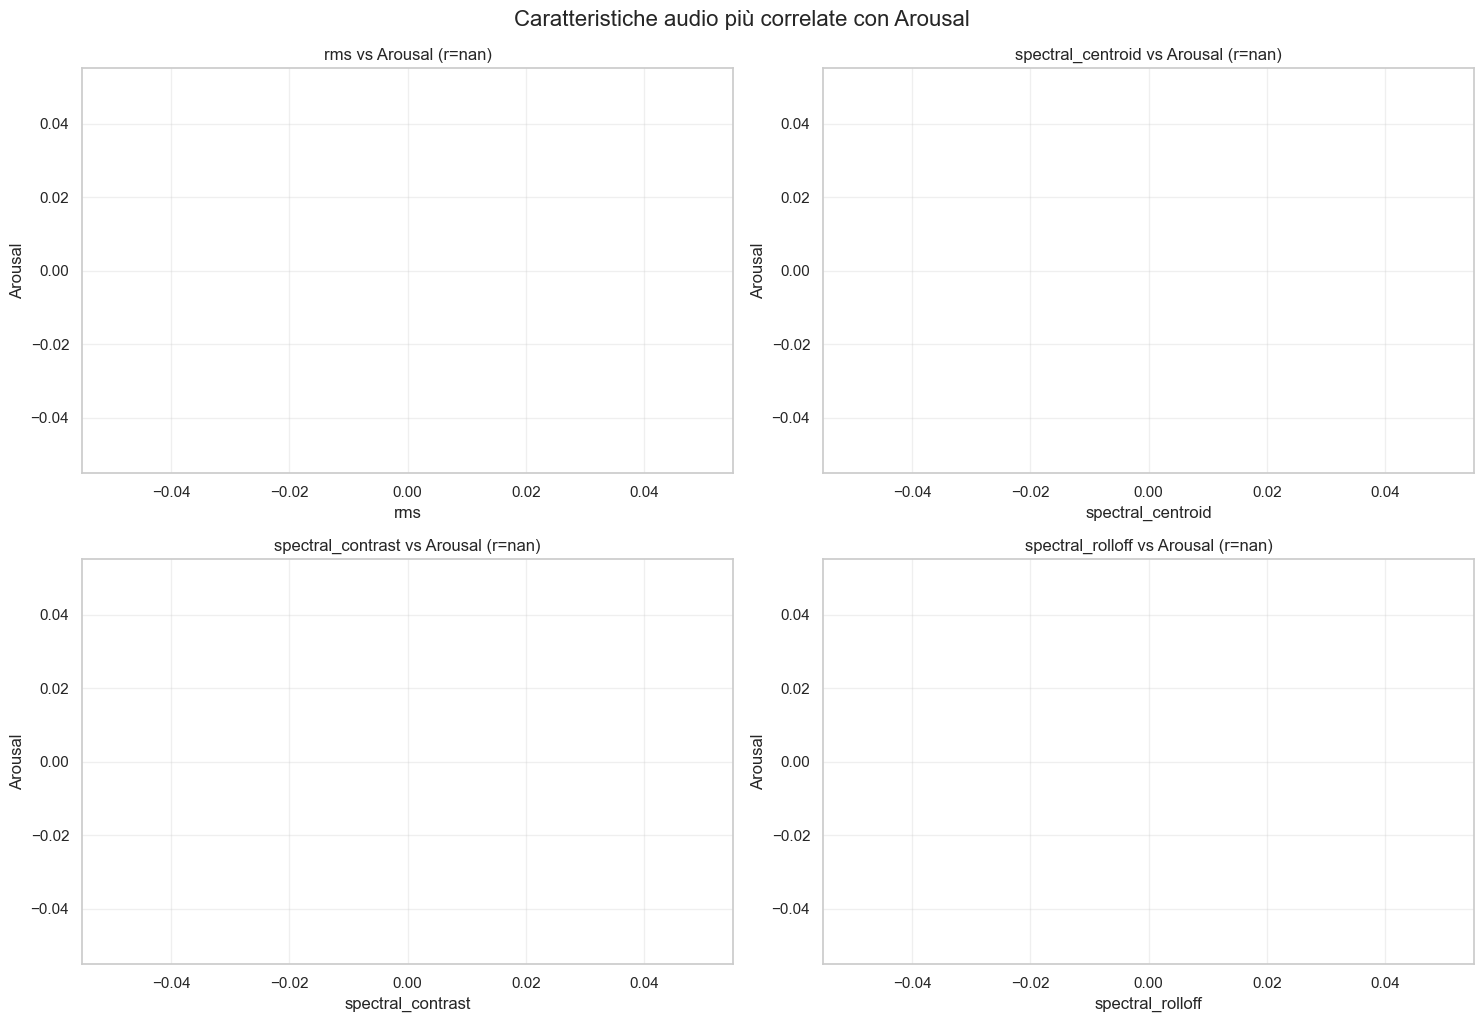

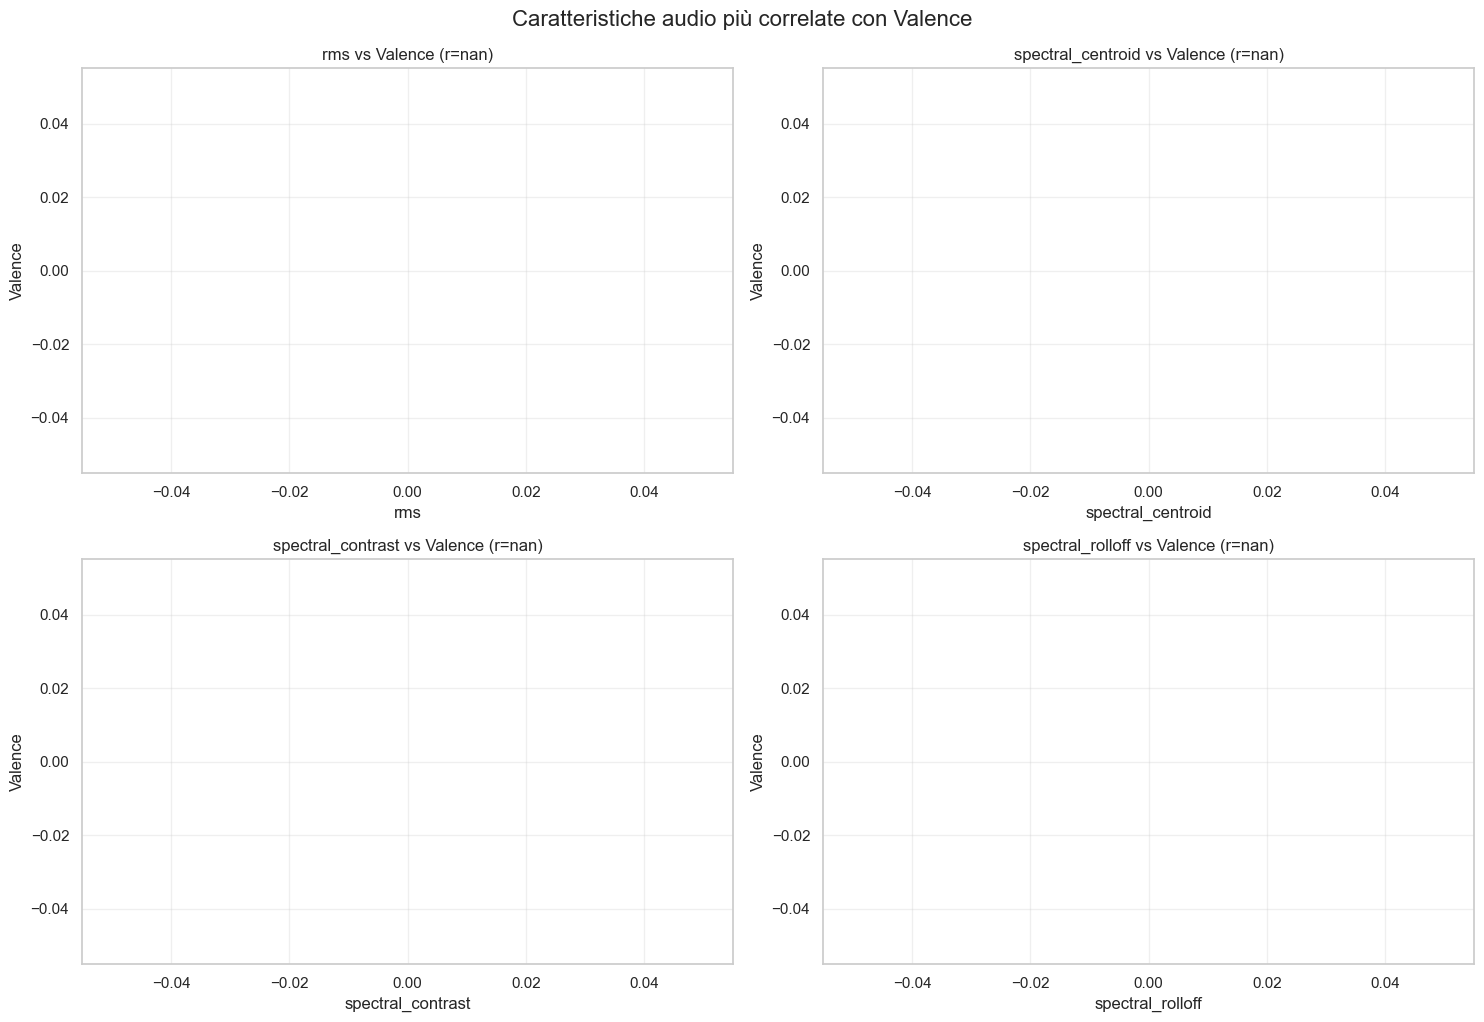

In [11]:
# Troviamo le caratteristiche più correlate con arousal e valence
top_arousal_features = arousal_correlations.abs().sort_values(ascending=False).head(4).index.tolist()
top_valence_features = valence_correlations.abs().sort_values(ascending=False).head(4).index.tolist()

# Creiamo scatter plot per le caratteristiche più correlate con arousal
plt.figure(figsize=(15, 10))
for i, feature in enumerate(top_arousal_features):
    plt.subplot(2, 2, i+1)
    sns.regplot(x=feature, y='arousal_mean', data=combined_df, scatter_kws={'alpha':0.6}, line_kws={'color':'red'})
    plt.title(f'{feature} vs Arousal (r={arousal_correlations[feature]:.2f})')
    plt.xlabel(feature)
    plt.ylabel('Arousal')
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.suptitle('Caratteristiche audio più correlate con Arousal', y=1.02, fontsize=16)
plt.show()

# Creiamo scatter plot per le caratteristiche più correlate con valence
plt.figure(figsize=(15, 10))
for i, feature in enumerate(top_valence_features):
    plt.subplot(2, 2, i+1)
    sns.regplot(x=feature, y='valence_mean', data=combined_df, scatter_kws={'alpha':0.6}, line_kws={'color':'green'})
    plt.title(f'{feature} vs Valence (r={valence_correlations[feature]:.2f})')
    plt.xlabel(feature)
    plt.ylabel('Valence')
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.suptitle('Caratteristiche audio più correlate con Valence', y=1.02, fontsize=16)
plt.show()

## 8. Conclusioni

In questo notebook, abbiamo esplorato come le caratteristiche audio estratte con Librosa si correlano con le emozioni (arousal e valence) a livello di canzone intera. Abbiamo visto come:

1. Alcune caratteristiche audio come RMS (energia), centroide spettrale (brillantezza) e tempo possono essere buoni predittori delle emozioni percepite
2. L'arousal (eccitazione) tende a correlarsi maggiormente con caratteristiche legate all'energia e al ritmo
3. La valence (positività) tende a correlarsi maggiormente con caratteristiche legate alla tonalità e alla brillantezza del suono
4. L'analisi a livello di canzone intera permette di identificare pattern più generali rispetto all'analisi temporale

Questo approccio di analisi a livello di canzone intera è complementare all'analisi temporale e permette di studiare un dataset più ampio di brani, fornendo una visione più completa di come le caratteristiche audio complessive influenzano la percezione emotiva della musica.